In [1]:
###############################################
# Section 1: Imports and Device Setup
###############################################
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
###############################################
# Section 2: Data Loading and Preprocessing
###############################################
with open("combined_cleaned.txt", "r", encoding="utf-8") as f:
    data = f.read()

chars = sorted(list(set(data)))
vocab_size = len(chars)
print(f"Vocabulary Size: {vocab_size}")

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

data_encoded = np.array([stoi[ch] for ch in data], dtype=np.int64)

Vocabulary Size: 305


In [3]:
###############################################
# Section 3: Model Definition and Hyperparameters
###############################################
class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers=1, dropout=0.0):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(vocab_size, hidden_size)
        # GRU applies dropout between layers if num_layers > 1
        self.rnn = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, hidden):
        x = self.embed(x)  # (batch, seq_len, hidden_size)
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)  # (batch*seq_len, vocab_size)
        return out, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

config = {
    'lr': 0.001,
    'batch_size': 128,
    'seq_length': 150,
    'hidden_size': 512,
    'dropout': 0.0,       
    'num_epochs': 10
}

model = CharRNN(vocab_size, config['hidden_size'], num_layers=1, dropout=config['dropout']).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

In [4]:
###############################################
# Section 4: Training Loop with Validation Split
###############################################
split_idx = int(0.9 * len(data_encoded))
train_data = data_encoded[:split_idx]
val_data = data_encoded[split_idx:]

def get_batch(data, batch_size, seq_length):
    indices = np.random.randint(0, len(data) - seq_length - 1, batch_size)
    x_batch = np.array([data[i:i+seq_length] for i in indices])
    y_batch = np.array([data[i+1:i+seq_length+1] for i in indices])
    return (torch.tensor(x_batch, dtype=torch.long).to(device),
            torch.tensor(y_batch, dtype=torch.long).to(device))

train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(config['num_epochs']):
    model.train()
    hidden = model.init_hidden(config['batch_size'])
    total_train_loss = 0
    num_train_batches = len(train_data) // (config['batch_size'] * config['seq_length'])
    
    for i in range(num_train_batches):
        inputs, targets = get_batch(train_data, config['batch_size'], config['seq_length'])
        hidden = hidden.detach()
        optimizer.zero_grad()
        outputs, hidden = model(inputs, hidden)
        loss = criterion(outputs, targets.view(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{config['num_epochs']}], Batch [{i+1}/{num_train_batches}], Loss: {loss.item():.4f}")
    
    avg_train_loss = total_train_loss / num_train_batches
    train_losses.append(avg_train_loss)
    
    # Validation loop
    model.eval()
    total_val_loss = 0
    num_val_batches = len(val_data) // (config['batch_size'] * config['seq_length'])
    val_hidden = model.init_hidden(config['batch_size'])
    with torch.no_grad():
        for i in range(num_val_batches):
            inputs, targets = get_batch(val_data, config['batch_size'], config['seq_length'])
            val_hidden = val_hidden.detach()
            outputs, val_hidden = model(inputs, val_hidden)
            loss = criterion(outputs, targets.view(-1))
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / num_val_batches
    val_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{config['num_epochs']}] Average Training Loss: {avg_train_loss:.4f}")
    print(f"Epoch [{epoch+1}/{config['num_epochs']}] Average Validation Loss: {avg_val_loss:.4f}")

print("Training complete.")

Starting training...
Epoch [1/10], Batch [100/231], Loss: 1.8920
Epoch [1/10], Batch [200/231], Loss: 1.6505
Epoch [1/10] Average Training Loss: 1.9767
Epoch [1/10] Average Validation Loss: 1.5757
Epoch [2/10], Batch [100/231], Loss: 1.5441
Epoch [2/10], Batch [200/231], Loss: 1.4628
Epoch [2/10] Average Training Loss: 1.5233
Epoch [2/10] Average Validation Loss: 1.4160
Epoch [3/10], Batch [100/231], Loss: 1.3986
Epoch [3/10], Batch [200/231], Loss: 1.4015
Epoch [3/10] Average Training Loss: 1.4128
Epoch [3/10] Average Validation Loss: 1.3641
Epoch [4/10], Batch [100/231], Loss: 1.4033
Epoch [4/10], Batch [200/231], Loss: 1.3606
Epoch [4/10] Average Training Loss: 1.3585
Epoch [4/10] Average Validation Loss: 1.3323
Epoch [5/10], Batch [100/231], Loss: 1.3245
Epoch [5/10], Batch [200/231], Loss: 1.3528
Epoch [5/10] Average Training Loss: 1.3239
Epoch [5/10] Average Validation Loss: 1.3278
Epoch [6/10], Batch [100/231], Loss: 1.2837
Epoch [6/10], Batch [200/231], Loss: 1.3062
Epoch [6/10

Model saved as 'char_rnn_model.pth'.

Generated Sample Text:
the of the matter credits and city cause all the malmö movies i get creature.
welcome two diracum really hard than i guess. it feel lucky is they based society ambailed it, and i definitely actually rather the contest in grate, skateboarding is usually different down to meet skating and but it matty… but that was a lindly was extrady to skate pokic is my distic there, i was like the part witar it. the apartmer for me. we think there’s really feeling her the serible was all magea they changed ‘i in s


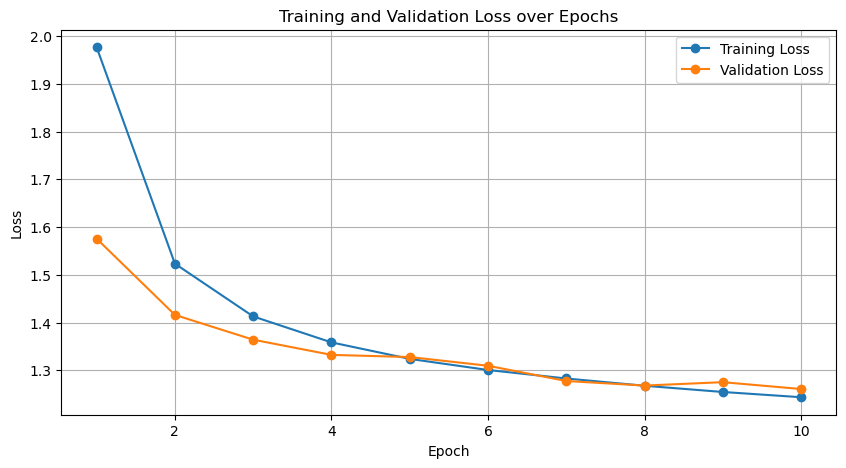

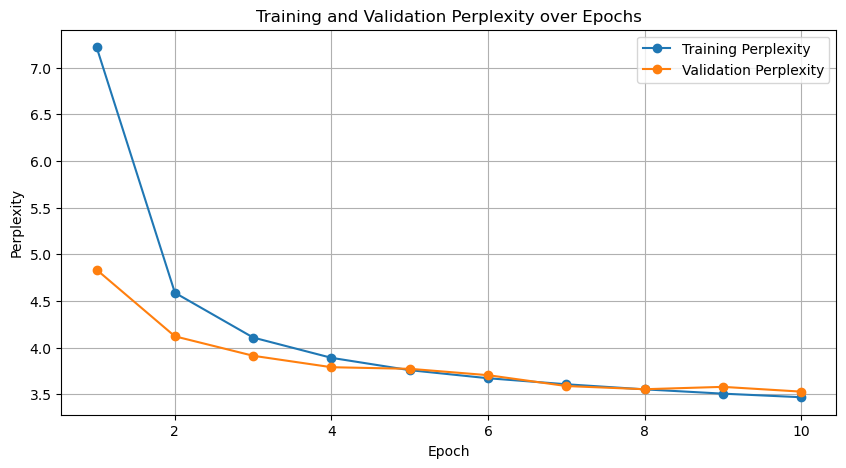

In [5]:
###############################################
# Section 5: Saving the Model, Generating Sample Text, and Plotting Metrics
###############################################
torch.save(model.state_dict(), "char_rnn_model.pth")
print("Model saved as 'char_rnn_model.pth'.")

try:
    df_existing = pd.read_csv('lvl2_log.csv')
    trial_number = df_existing['experiment_number'].max() + 1
except FileNotFoundError:
    trial_number = 1

def generate_text(model, start_text="the ", length=300, temperature=1.0):
    start_text = start_text.lower()
    chars_generated = list(start_text)
    hidden = model.init_hidden(1)
    input_seq = torch.tensor([[stoi[ch] for ch in start_text if ch in stoi]], dtype=torch.long).to(device)
    _, hidden = model(input_seq, hidden)
    last_char = input_seq[0, -1]
    for _ in range(length):
        output, hidden = model(last_char.view(1, 1), hidden)
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        char = itos[top_i.item()]
        chars_generated.append(char)
        last_char = torch.tensor([stoi[char]], dtype=torch.long).to(device)
    return "".join(chars_generated)

sample_text = generate_text(model, start_text="The ", length=500)
print("\nGenerated Sample Text:")
print(sample_text)

with open("lvl2_output.txt", "a", encoding="utf-8") as f:
    f.write(f"\nTrial {trial_number} Sample Text:\n")
    f.write(sample_text)
    f.write("\n" + "="*50 + "\n")

epochs = np.arange(1, config['num_epochs'] + 1)
train_perplexities = [np.exp(loss) for loss in train_losses]
val_perplexities = [np.exp(loss) for loss in val_losses]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("loss_over_epochs.png")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_perplexities, marker='o', label='Training Perplexity')
plt.plot(epochs, val_perplexities, marker='o', label='Validation Perplexity')
plt.title('Training and Validation Perplexity over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True)
plt.savefig("perplexity_over_epochs.png")
plt.show()

In [6]:
###############################################
# Section 6: Experiment Logging and Results Display
###############################################
def log_experiment(observations="", csv_path='lvl2_log.csv'):
    
    global config, train_losses, val_losses
    current_train_loss = train_losses[-1]
    current_val_loss = val_losses[-1]
    
    try:
        df_existing = pd.read_csv(csv_path)
        next_trial = df_existing['experiment_number'].max() + 1
    except FileNotFoundError:
        df_existing = None
        next_trial = 1

    data = {
        'experiment_number': next_trial,
        'learning_rate': config.get('lr'),
        'batch_size': config.get('batch_size'),
        'seq_length': config.get('seq_length'),
        'hidden_size': config.get('hidden_size'),
        'dropout': config.get('dropout', 0.0),
        'num_epochs': config.get('num_epochs'),
        'training_loss': current_train_loss,
        'validation_loss': current_val_loss,
        'training_perplexity': np.exp(current_train_loss),
        'validation_perplexity': np.exp(current_val_loss),
        'observations': observations
    }
    
    df_new = pd.DataFrame([data])
    if df_existing is not None:
        df = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        df = df_new

    df.to_csv(csv_path, index=False)
    return df

experiment_results = log_experiment(observations="combined best parameters")
print("Experiment Results:")
print(experiment_results)

Experiment Results:
   experiment_number  learning_rate  batch_size  seq_length  hidden_size  \
0                  1          0.003          64         100          256   
1                  2          0.001          64         100          256   
2                  3          0.005          64         100          256   
3                  4          0.003          32         100          256   
4                  5          0.003         128         100          256   
5                  6          0.003          64          50          256   
6                  7          0.003          64         150          256   
7                  8          0.003          64         100          128   
8                  9          0.003          64         100          512   
9                 10          0.001         128         150          512   

   dropout  num_epochs  training_loss  validation_loss  training_perplexity  \
0      0.0          10       1.366672         1.360600          